# Data 608 Story #7

by Jean Jimenez

# Where Do Strategic Minerals Come From?

## Introduction

The US Geological Survey publishes a list of Strategic Minerals ( https://www.usgs.gov/news/national-news-release/us-geological-survey-releases-2022-list-critical-minerals ). Having a secure supply of these minerals is essential to our security and economic prosperity. However many of these minerals are sourced from outside of the US. This assignment is to develop a reference catalog of the source or sources of each of these minerals and a judgement on the reliability of each source under stressed circumstance (e.g. war, economic crisis, etc.).

It is important to study and analyze data on strategic minerals, which are the raw material of many important products. The strategic minerals tracked by the US Geological Survey linked above serve as the backbone of many American industries (such as construction , medical/ pharmaceuticals , and military.). We are seeing increasing instability due to the advent of various wars and inflation. As a result, the Biden administration has been attempting to strengthen the American workforce. Increasing investments in developing infrastructure, the micro-chip industry, and the clean energy/ electric vehicle push has increased the United State's appetite for raw minerals.

Different minerals are located in only certain geographic locations. Certain minerals only form when there is ideal geological conditions. As a result, minerals are scattered around the world. Also, different places have different abilities to mine and process certain minerals. The United States must obtain and import minerals it cannot find here. This is an analysis of minerals that are imported by the United States.

## Data Source and Collection

Data for this analysis come from the 2022 list of Strategic Minerals ( https://www.usgs.gov/news/national-news-release/us-geological-survey-releases-2022-list-critical-minerals ).

For each element listed, data was collected on the proportional breakdown of the imported element for that year.

After collecting data, countries were labeled either Ally, Neutral, or Competitor based on the geopolitical conditions of 2022.


## Where are the Minerals being imported from?




In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches 


file_path = 'merged_elements_data.csv'  
data = pd.read_csv(file_path)

In [15]:
reshaped_data = []
for i in range(1, 6):
    source_col = f"source_{i}"
    prop_col = f"s{i}_prop"
    type_col = f"s{i}_type"
    temp_df = data[['Element', source_col, prop_col, type_col]]
    temp_df.columns = ['Element', 'Country', 'Proportion', 'Type'] 
    reshaped_data.append(temp_df[['Element', 'Type', 'Proportion']])


long_data = pd.concat(reshaped_data, ignore_index=True)
long_data.dropna(inplace=True)


type_grouped = long_data.groupby(['Element', 'Type']).sum().reset_index()


type_grouped['Normalized'] = type_grouped.groupby('Element')['Proportion'].transform(lambda x: x / x.sum() * 100)


order = ['Competitor', 'Ally', 'Neutral']
type_grouped['Type'] = pd.Categorical(type_grouped['Type'], categories=order, ordered=True)
type_grouped.sort_values(by='Type', inplace=True)


pivot_data_type = type_grouped.pivot(index='Element', columns='Type', values='Normalized')

The following figure shows the Proportion each element by source type (Ally, Competitor, or Neutral)

Elements where 50% or more are imported from a competitor country are flagged.

<Figure size 1400x800 with 0 Axes>

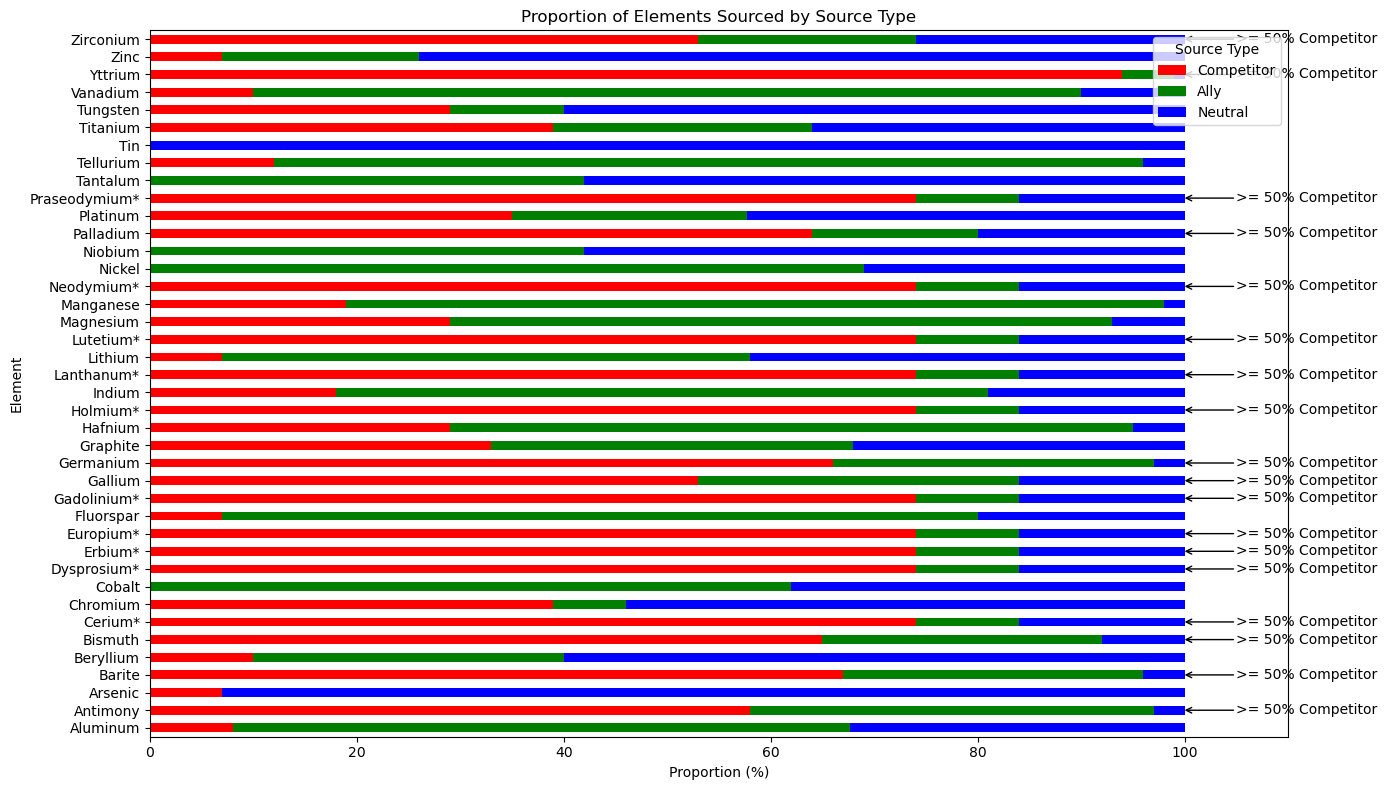

In [22]:
type_colors = {'Competitor': 'red', 'Ally': 'green', 'Neutral': 'blue'}


plt.figure(figsize=(14, 8))  
ax = pivot_data_type.plot(kind='barh', stacked=True, figsize=(14, 8), color=[type_colors.get(x) for x in order])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:3], labels=labels[:3], title='Source Type', loc='upper right')


ax.set_xlim(0, 110)


for i, (index, row) in enumerate(pivot_data_type.iterrows()):
    if row.get('Competitor', 0) >= 50:
        
        annotation_x_position = 105  
        ax.annotate('>= 50% Competitor', xy=(100, i), xytext=(annotation_x_position, i),
                    color='black', ha='left', va='center', 
                    arrowprops=dict(arrowstyle='->', color='black', shrinkA=0, shrinkB=0))

plt.xlabel('Proportion (%)')
plt.title('Proportion of Elements Sourced by Source Type')
plt.tight_layout()
plt.show()

Out of the 40 elements listed, 18 are sourced from a competitor (50% or more of imported source).

That is a lot. That means that almost 50% of the elements we depend on we are getting most of it from competing nations.


The following map shows the countries where we import these strategic minerals from.

C:\Users\bleac\AppData\Local\Temp\ipykernel_9560\1803346516.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


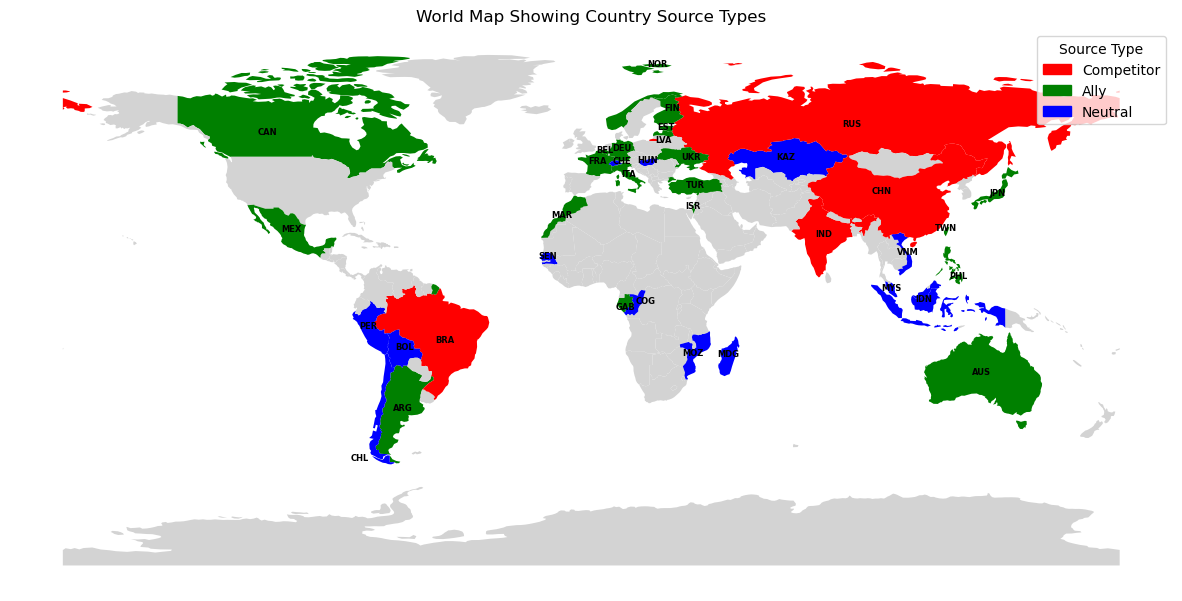

In [43]:
reshaped_data = []
for i in range(1, 6):
    source_col = f"source_{i}"
    prop_col = f"s{i}_prop"
    type_col = f"s{i}_type"
    temp_df = data[['Element', source_col, prop_col, type_col]]
    temp_df.columns = ['Element', 'Country', 'Proportion', 'Type']
    reshaped_data.append(temp_df)

combined_data = pd.concat(reshaped_data, ignore_index=True)
combined_data.dropna(inplace=True)


country_types = combined_data.groupby(['Country', 'Type']).sum().reset_index()

dominant_type = country_types.loc[country_types.groupby('Country')['Proportion'].idxmax()]


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


world = world.merge(dominant_type, how='left', left_on='name', right_on='Country')


color_map = {'Competitor': 'red', 'Ally': 'green', 'Neutral': 'blue'}
world['color'] = world['Type'].map(color_map)


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color=world['color'].fillna('lightgrey'))  
for idx, row in world.iterrows():
    if pd.notna(row['Type']): 
        text = row['iso_a3']  
        x, y = row['geometry'].representative_point().x, row['geometry'].representative_point().y
        
       
        if text == "COG":  
            x += 2.5  
        if text == "GAB":  
            y -= 2  

        if text == "CHE":  
            x += 2 

        if text == "CHL":  
            x -= 9

        if text == "LVA":  
            y -= 3

        
        plt.annotate(text=text, xy=(x, y),
                     horizontalalignment='center', fontsize=6, color='black', fontweight='bold')



legend_labels = {'Competitor': 'red', 'Ally': 'green', 'Neutral': 'blue'}
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
ax.legend(handles=legend_handles, title='Source Type')
ax.set_title('World Map Showing Country Source Types')
ax.set_axis_off()  
plt.show()

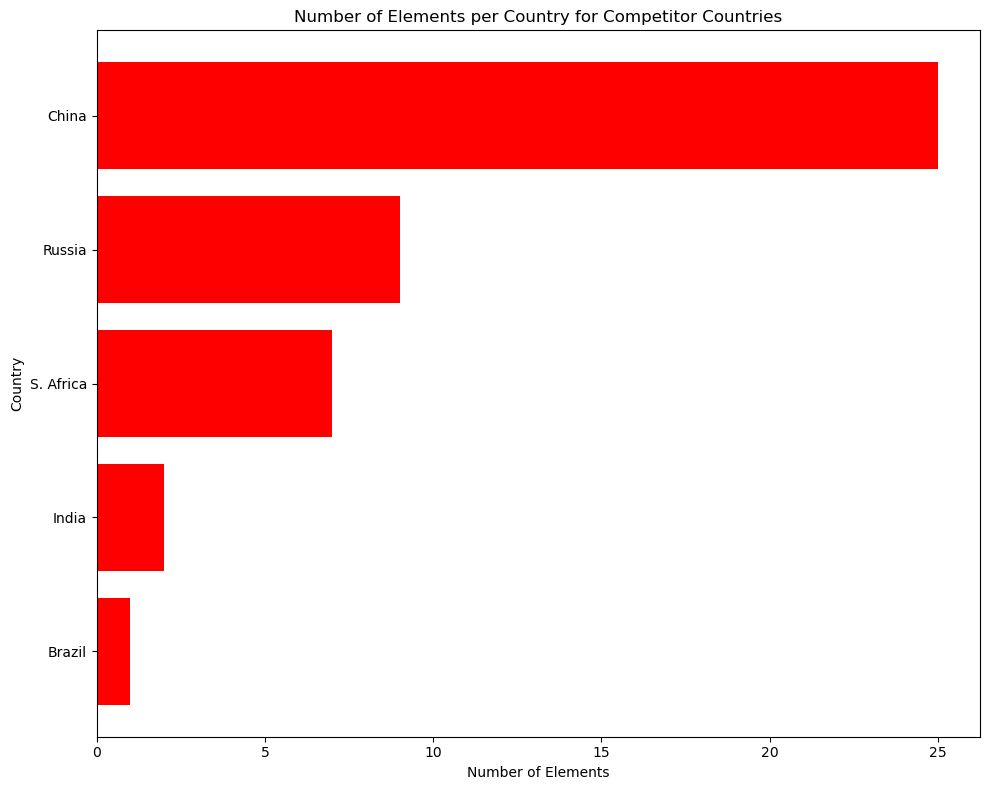

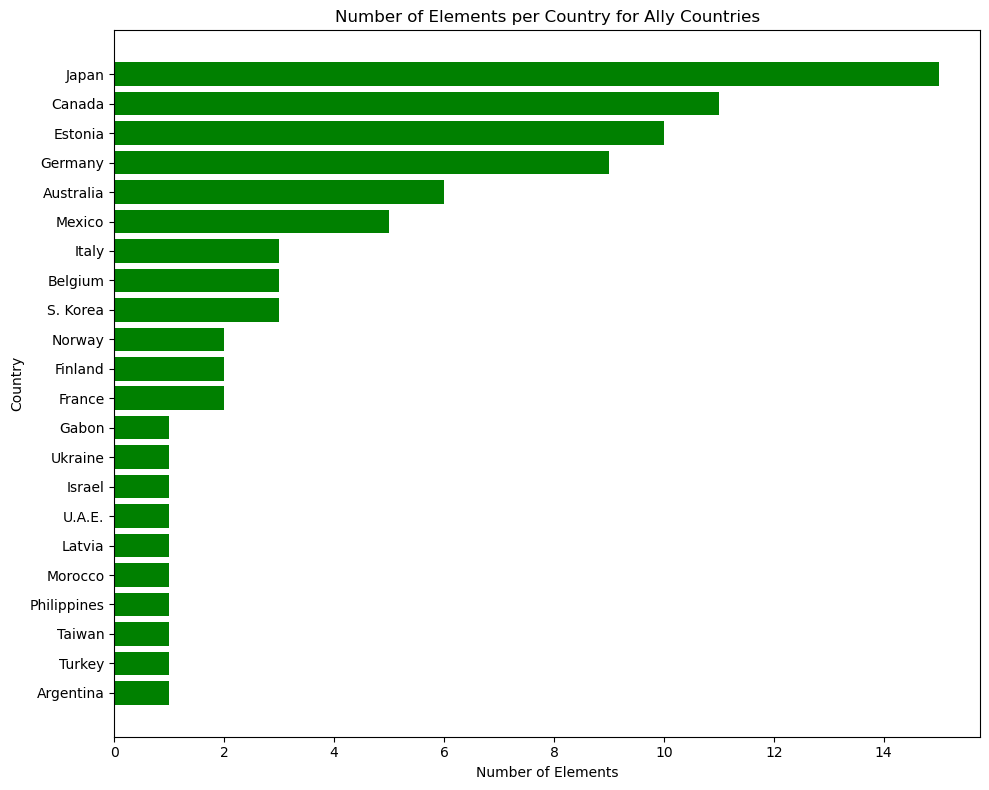

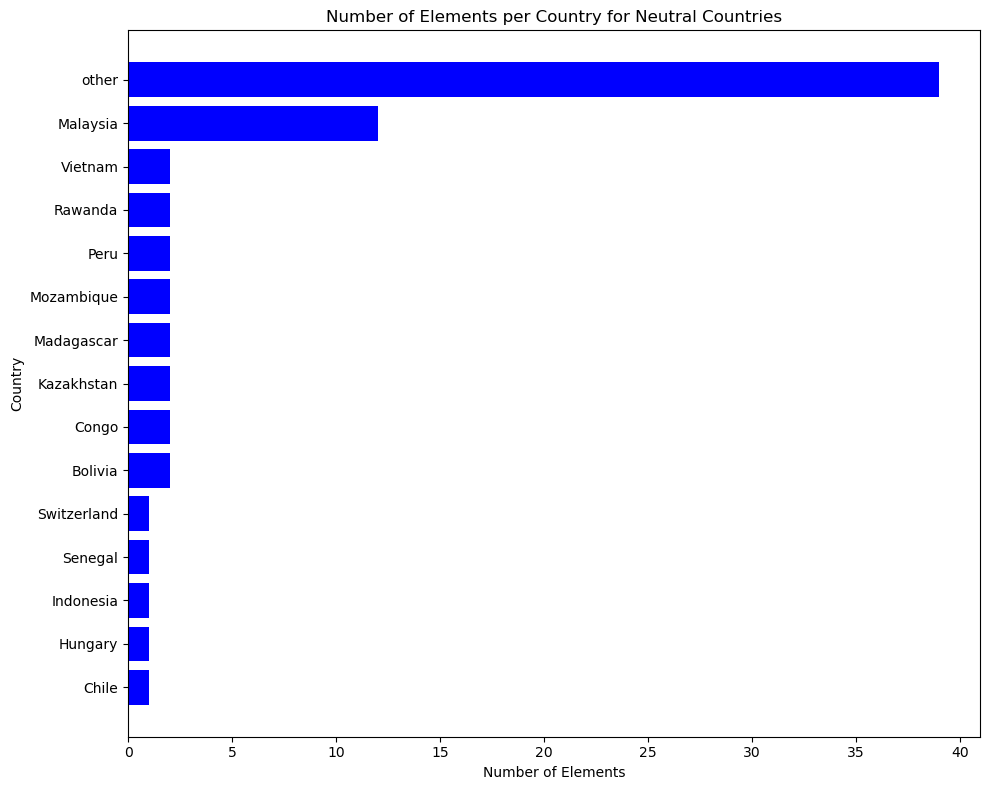

In [45]:
combined_data = pd.concat(reshaped_data, ignore_index=True)
combined_data.dropna(inplace=True)

country_element_count = combined_data.groupby(['Country', 'Type'])['Element'].nunique().reset_index()


competitor_data = country_element_count[country_element_count['Type'] == 'Competitor']
ally_data = country_element_count[country_element_count['Type'] == 'Ally']
neutral_data = country_element_count[country_element_count['Type'] == 'Neutral']


type_colors = {'Competitor': 'red', 'Ally': 'green', 'Neutral': 'blue'}


def plot_country_elements(data, type_label):
    fig, ax = plt.subplots(figsize=(10, 8))
    data = data.sort_values(by='Element', ascending=True)  
    ax.barh(data['Country'], data['Element'], color=type_colors[type_label])  
    ax.set_xlabel('Number of Elements')
    ax.set_ylabel('Country')
    ax.set_title(f'Number of Elements per Country for {type_label} Countries')
    plt.tight_layout()
    plt.show()


plot_country_elements(competitor_data, 'Competitor')
plot_country_elements(ally_data, 'Ally')
plot_country_elements(neutral_data, 'Neutral')

For competing nations, we import most elements from China. This is followed by Russia and South Africa.

(South Africa, Brazil, India labeled as competing nations due to their BRICS economic union).

From Ally countries, we import the most from Japan, followed by Canada, Estonia, Germany, Australia and Mexico.

From Neutral countries, we import the most from Malaysia, followed by Vietnam, Rwanda, and Peru.

In [46]:
def get_elements_for_country(country_name):
    
    filtered_data = combined_data[combined_data['Country'] == country_name]
    
    unique_elements = filtered_data['Element'].unique()
    return unique_elements


elements_china = get_elements_for_country('China')
elements_russia = get_elements_for_country('Russia')
elements_france = get_elements_for_country('France')


print("Elements associated with China:", elements_china)
print("Elements associated with Russia:", elements_russia)
print("Elements associated with France:", elements_france)

Elements associated with China: ['Antimony' 'Barite' 'Bismuth' 'Cerium*' 'Dysprosium*' 'Erbium*'
 'Europium*' 'Gadolinium*' 'Gallium' 'Germanium' 'Graphite' 'Holmium*'
 'Lanthanum*' 'Lutetium*' 'Neodymium*' 'Praseodymium*' 'Tungsten'
 'Yttrium' 'Arsenic' 'Hafnium' 'Indium' 'Lithium' 'Tellurium' 'Zinc'
 'Aluminum']
Elements associated with Russia: ['Palladium' 'Magnesium' 'Aluminum' 'Chromium' 'Vanadium' 'Germanium'
 'Hafnium' 'Lithium' 'Zirconium']
Elements associated with France: ['Hafnium' 'Indium']


### Russia

Elements that are imported from Russia are:  ['Palladium' 'Magnesium' 'Aluminum' 'Chromium' 'Vanadium' 'Germanium'
 'Hafnium' 'Lithium' 'Zirconium'].


Since the Russian invasion of Ukraine, the United States imposed economic sanctions meant to take a stab in the Russian Economy. However, Russia is a source of minerals so the sanctions still do not cover some of these strategic materials. While we are engaged in a proxy war with Russia through Ukraine, we still depend on Russian resources to build many of the rockets, drones, and shells used in the war. The Russian governments big source of income is resource extraction so they will continue to sell to fund their war. If the United States is truly interested in defeating Vladimir Putin, it should impose stricter sanctions against the state and end dependence on these minerals.

### China

Elements that are imported from China are: ['Antimony' 'Barite' 'Bismuth' 'Cerium*' 'Dysprosium*' 'Erbium*'
 'Europium*' 'Gadolinium*' 'Gallium' 'Germanium' 'Graphite' 'Holmium*'
 'Lanthanum*' 'Lutetium*' 'Neodymium*' 'Praseodymium*' 'Tungsten'
 'Yttrium' 'Arsenic' 'Hafnium' 'Indium' 'Lithium' 'Tellurium' 'Zinc'
 'Aluminum'].


China is a competitor state to the United States. While not actively engaged in combat, the United States and People's Republic of China constantly butt heads over the sovereignty of the Republic of China and South China Sea. PRC and the U.S. constantly engage in cyber warfare and covert espionage. However, we are dependent to the PRC to obtain these strategic minerals. The PRC is a rich source of minerals geologically and has the mines and man power to extract those minerals. Many of the minerals used in electric cars are from PRC. PRC is considered to be the US main competitor. The US should look for alternate mineral sources.


## Conclusion

The United States is too dependent on competing nations for strategic minerals. The US should look for alternate source of minerals in nations that we are likely not to go to war against. With increasing global tensions, the chances of a war with China or Russia are possible. 

While the Biden administration is increasingly investing in Strategic mineral mining in the US, people argue against the creation of new mines due to the pollution and environmental harm done to communities. The US should temporarily increase internal mining and also find alternate mineral sources. They should simultaneously invest in space programs and ultimately aim to extract strategic minerals from out of planet places (starting with the moon).